## Ray Tracer Implementation

In [64]:
class Ray():

    def __init__(self, rStart, rDir):

      self.start = rStart
      self.dir = rDir

Blinn Phong Model describes the followin properties for any material to be rendered:

- Ambient color: color that an object is suppose to have in absence of light.
- Diffuse color: color that is the closest to what we think of when we say “color”;
- Specular color: color of the shiny part of an object when light has stroke on it. White most of the time.
- Shininess: a coefficient representing how shiny an object is;


In [65]:
class Material():

  """ defines the color of the objects as well has how much they reflect the light. Blin-Phong Model"""

  def __init__(self, ambient, diffuse, specular, shininess):

    """ constructor based on the model """

    self.ambient = ambient

    self.diffuse = diffuse

    self.specular = specular

    self.shininess = shininess


Generic class for any object suitable to be rendered. All of those objects are created by signed distance functions, any concrete definition must implement the following methods.

In [66]:
import math

import numpy as np

from tqdm import tqdm

In [67]:
class RenderObject():

  """ define common properties for SDF objects """

  def __init__(self, mat: Material):

    self.EPSILON = 0.000001
    self.material = mat

  def intersect(self, r: Ray) -> bool : pass

  def normalVectorToSurfaceAtPoint(self, point: np.array) -> np.array	: pass

In [68]:
class Sphere(RenderObject):

  def __init__(self, sPos, sSize, mat):

    super().__init__(mat)

    self.center = sPos
    self.radius = sSize

  def normalVectorToSurfaceAtPoint(self, point) :

    pass

  def intersect(self, r: Ray):

    b = 2 * np.dot(r.dir, r.start - self.center)
    c = np.linalg.norm(r.start - self.center) ** 2 - self.radius ** 2
    delta = b ** 2 - 4 * c
    if delta > 0:
        t1 = (-b + np.sqrt(delta)) / 2
        t2 = (-b - np.sqrt(delta)) / 2
        if t1 > 0 and t2 > 0:
            return min(t1, t2)
    return None

We can write signed distance functions for other type of 3D objects. Since we already have an abstract class for any object that can be rendered, we'll use it to create a concrete implementations of a box.

In [69]:
class Box(RenderObject):

  def __init__(self, p, b, mat):

    super().__init__(mat)

    self.center = p

    self.b = b

  def normalVectorToSurfaceAtPoint(self, point) :

    pass

  def intersect(self, r: Ray):

    tMin = (self.center - r.start) / r.dir
    tMax = (self.b - r.start) / r.dir

    t1 = np.minimum(tMin, tMax)
    t2 = np.maximum(tMin, tMax)

    # 0,1,2 -> x,y,z;

    tNear = max(max(t1[0], t1[1]), t1[2])
    tFar = min(min(t2[0], t2[1]), t2[2])

    if( tNear>tFar or tFar <0.0) : return None; # no intersection

    return min(tNear, tFar)

In [70]:
def magnitude(vector):

    return math.sqrt(sum(pow(element, 2) for element in vector))

In [71]:
def _length(a):

    return np.linalg.norm(a, axis=1)

In [72]:
_min = np.minimum
_max = np.maximum

In [73]:
class Light():

    """ The Blinn-Phong model states that light also has three color properties """

    def __init__(self, lPos, ambient, diffuse, specular):

      """ constructor based on the model """

      self.lPos = lPos

      self.ambient = ambient

      self.diffuse = diffuse

      self.specular = specular

In [74]:
# loop for objects , keep the nearest sphere:

def nearest_intersected_object(objects, ray):

    # using the rendered object:

    distances = [obj.intersect(ray) for obj in objects]
    nearest_object = None
    min_distance = np.inf

    # loop through distances:

    for index, distance in enumerate(distances):

        if distance and distance < min_distance:
            min_distance = distance
            nearest_object = objects[index]

    return nearest_object, min_distance

In [75]:
def normalize(vector):
    return vector / np.linalg.norm(vector)

In [76]:
light = Light(

    lPos = np.array([5, 5, 5]),
    ambient = np.array([1, 1, 1]),
    diffuse = np.array([1, 1, 1]),
    specular = np.array([1, 1, 1])
)

In [77]:
# the scene object must contain light and objects:

class Scene():

  """ object oriented way """

  def __init__(self, objects):

    self.objects = objects

In [78]:
m0 = Material(
    ambient = np.array([0.1, 0, 0]),
    diffuse = np.array([0.7, 0, 0]),
    specular = np.array([1, 1, 1]),
    shininess = 100
)

s0 = Sphere(np.array([-0.2, 0, -1]), sSize = 0.2, mat = m0)
s1 = Sphere(np.array([-0.2, -0.3, 0]), sSize = 0.1, mat = m0)
b1 = Box(np.array([1.2, 1.3, -2]), np.array([0.1, 0.1, 0.1]), mat = m0)
s2 = Sphere(np.array([-0.3, -0.3, 0]), sSize = 0.25, mat = m0)

# create a scene based on the objects:

scene = Scene([s0, s1, b1, s2])

In [79]:
class Tracer():

  def __init__(self):

    """ basic image parms """

    self.width = 300
    self.height = 200

    self.camera = np.array([0, 0, 1])
    self.ratio = self.width / self.height
    self.screen = (-1, 1 / self.ratio, 1, -1 / self.ratio)

  def render(self, scene):

    """ render the image based on ray tracer technique """

    image = np.zeros((self.height, self.width, 3))

    for i, y in tqdm(enumerate(np.linspace(self.screen[1], self.screen[3], self.height))):

        for j, x in enumerate(np.linspace(self.screen[0], self.screen[2], self.width)):

            pixel = np.array([x, y, 0])
            origin = self.camera
            direction = normalize(pixel - origin)

            # instantiate ray from camera to direction
            ray = Ray(origin, direction)

            # check for intersections
            nearest_object, min_distance = nearest_intersected_object(scene.objects, ray)

            if nearest_object is None:
                continue

            # compute intersection point between the ray and nearest object
            intersection = origin + min_distance * direction
            normal_to_surface = normalize(intersection - nearest_object.center)
            shifted_point = intersection + 1e-5 * normal_to_surface
            intersection_to_light = normalize(light.lPos - shifted_point)

            # ray light
            ray_light = Ray(shifted_point, intersection_to_light, 1.0)

            _, min_distance = nearest_intersected_object(scene.objects, ray_light)
            intersection_to_light_distance = np.linalg.norm(light.lPos - intersection)
            is_shadowed = min_distance < intersection_to_light_distance

            # Blinn-Phong Model (RGB)
            illumination = np.zeros((3))
            # ambient
            illumination += nearest_object.material.ambient * light.ambient
            # diffuse
            illumination += nearest_object.material.diffuse * light.diffuse * np.dot(intersection_to_light, normal_to_surface)
            # specular
            intersection_to_camera = normalize(self.camera - intersection)
            H = normalize(intersection_to_light + intersection_to_camera)
            illumination += nearest_object.material.specular * light.specular * np.dot(normal_to_surface, H) ** (nearest_object.material.shininess / 4)

            image[i, j] = np.clip(illumination, 0, 1)

    return image

In [80]:
import matplotlib.pyplot as plt

import matplotlib.image as mpimg

In [81]:
t = Tracer()

image = t.render(scene)

plt.imsave('scene.png', image)

0it [00:00, ?it/s]


TypeError: Ray.__init__() takes 3 positional arguments but 4 were given

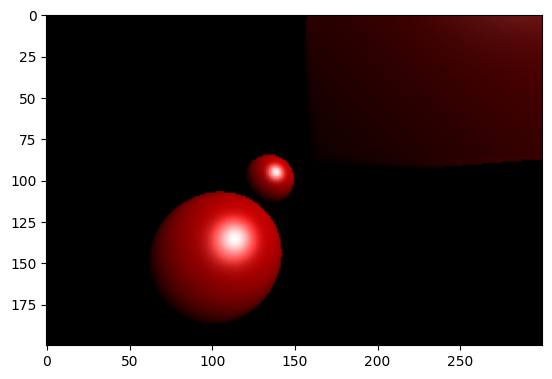

In [ ]:
plt.imshow(mpimg.imread('scene.png'))